In [1]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-07-31', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-02


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,237152452608,1.028849,36804000000,Technology,2.882000,54.396709,42.582268,56.470001,55.400002,55.389999,53.250000,17441200.0
SITC,2572780544,0.870377,1499137000,Real Estate,1.043000,13.070000,NaN,14.130000,14.250000,14.100000,14.060000,1716149.0
UAL,23613609984,1.278593,10320000000,Industrials,9.838000,88.449997,81.209999,93.930000,91.910004,90.489998,89.430000,2125300.0
TROW,26710714368,1.029243,6579100000,Financial Services,7.945000,109.050003,113.295105,115.360001,113.389999,110.470001,110.050003,1951700.0
ISRG,59875086336,1.289684,7265300000,Healthcare,10.128999,529.309998,520.359985,531.640015,519.510010,523.950012,513.599976,593300.0


In [4]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-02')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [5]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2017-05-12,21.299999,20.270000,21.250000,21.10,10933700.0,21.10,GDI
1,2017-05-15,22.299999,21.010000,21.010000,22.02,3487300.0,22.02,GDI
2,2017-05-16,22.410000,22.049999,22.190001,22.10,1289300.0,22.10,GDI
3,2017-05-17,22.510000,21.670000,22.150000,22.10,1583700.0,22.10,GDI
4,2017-05-18,23.629999,21.980000,22.190001,22.50,4075200.0,22.50,GDI


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=3)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
p = transform_prices(prices, '2018-12-31')
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
returns.head()

(754, 903)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUM,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.016211,-0.034002,0.011495,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.015965,...,-0.011499,-0.058347,-0.002256,-0.007603,-0.045370,-0.014372,-0.058756,-0.021612,-0.037313,-0.013564
2016-01-05,-0.003441,-0.045314,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.022861,...,-0.002493,-0.005427,0.015077,0.020823,-0.025117,-0.014582,-0.019176,-0.010857,-0.007752,0.015654
2016-01-06,0.004439,-0.071197,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,0.005528,...,-0.007080,-0.001364,0.002599,0.004330,-0.039957,-0.014408,-0.006656,-0.029145,0.003906,0.000209
2016-01-07,-0.042475,-0.039489,-0.018918,0.011073,-0.042204,-0.002963,-0.031932,-0.039625,-0.023966,-0.017447,...,-0.034116,-0.020947,-0.046296,-0.022993,-0.045316,-0.035559,-0.036013,-0.030020,-0.035019,-0.030404
2016-01-08,-0.010513,-0.024184,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.014595,...,-0.013607,0.027907,0.000000,-0.004217,-0.002693,-0.030725,0.037793,-0.011254,-0.028226,-0.014605


In [7]:
p.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,YUM,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,40.439266,23.386749,40.896172,149.595322,99.032730,50.860046,97.531143,90.279999,41.523396,35.983860,...,48.688587,23.480000,26.590000,101.306412,69.650002,26.440001,26.040001,25.907946,2.68,46.664272
2016-01-04,39.355980,23.007635,39.505604,151.314865,99.117409,49.460629,95.800774,85.239998,39.692707,35.409374,...,48.128719,22.110001,26.530001,100.536179,66.489998,26.059999,24.510000,25.348028,2.58,46.031315
2016-01-05,39.220570,21.965065,39.128994,150.281174,96.633583,49.254574,97.201996,85.000000,39.683453,36.218876,...,48.008751,21.990000,26.930000,102.629654,64.820000,25.680000,24.040001,25.072823,2.56,46.751911
2016-01-06,39.394669,20.401209,39.814610,146.305466,94.742485,49.263153,95.716133,85.300003,39.350605,36.419083,...,47.668831,21.959999,27.000000,103.074013,62.230000,25.309999,23.879999,24.342087,2.57,46.761662
2016-01-07,37.721378,19.595585,39.061390,147.925568,90.743942,49.117207,92.659752,81.919998,38.407528,35.783661,...,46.042538,21.500000,25.750000,100.704056,59.410000,24.410000,23.020000,23.611343,2.48,45.339909


In [8]:
def create_momentum_factor(prices, data):

    # demean by sector
    sector_data = data['sector']
    index_ = sector_data.index.intersection(prices.columns)
    sector_data = sector_data.loc[index_]
    prices = prices.loc[:, index_].copy() # to use only the stocks that are in sector_data
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [9]:
momentum = create_momentum_factor(p, data)
print(momentum.shape)
momentum.head()

(503, 881)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,BWA,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-30,-0.188630,0.314383,-0.687712,0.911709,-0.282944,-1.634789,1.379353,0.334031,0.078596,1.442230,...,-0.275085,-0.070736,0.294734,-0.212208,-0.840973,1.308617,-0.125753,-1.512966,-0.294734,-1.351845
2017-01-03,-0.141472,0.345821,-0.679852,0.821324,-0.113964,-1.634789,1.355775,0.086455,0.235787,1.414721,...,-0.322242,0.074666,0.255436,-0.168981,-0.754518,1.320407,-0.102174,-1.505106,-0.231857,-1.336126
2017-01-04,-0.275085,0.408697,-0.730939,0.593397,-0.271155,-1.634789,1.347915,0.051087,0.117893,1.418651,...,-0.420487,-0.003930,0.326172,-0.121823,-0.671993,1.402932,0.161121,-1.520825,-0.322242,-1.371494
2017-01-05,-0.282944,0.058947,-0.675922,0.546240,-0.263295,-1.642649,1.324336,0.031438,0.491223,1.410791,...,-0.334031,-0.070736,0.385119,-0.161121,-0.550169,1.450089,0.330102,-1.524755,-0.330102,-1.340055
2017-01-06,-0.404767,0.298663,-0.766307,0.546240,-0.318312,-1.654438,1.340055,-0.090385,0.770237,1.391143,...,-0.420487,-0.039298,0.389048,-0.255436,-0.180770,1.536544,0.593397,-1.509036,-0.220068,-1.324336


In [10]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [11]:
smoothed_momentum = create_smoothed_factor(momentum, 5)
print(smoothed_momentum.shape)
smoothed_momentum.head()

(499, 881)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,BWA,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-06,-0.239717,0.259366,-0.711290,0.703431,-0.235787,-1.642649,1.367564,0.082525,0.345821,1.418651,...,-0.365470,-0.007860,0.326172,-0.180770,-0.616976,1.410791,0.165051,-1.528685,-0.282944,-1.332196
2017-01-09,-0.314383,0.282944,-0.742729,0.605186,-0.267225,-1.650508,1.351845,0.015719,0.444065,1.402932,...,-0.400838,-0.023579,0.353680,-0.192559,-0.471574,1.461879,0.345821,-1.520825,-0.251506,-1.324336
2017-01-10,-0.361540,0.353680,-0.766307,0.522661,-0.290804,-1.654438,1.351845,-0.051087,0.542310,1.391143,...,-0.416557,-0.141472,0.361540,-0.216138,-0.322242,1.512966,0.526591,-1.473668,-0.267225,-1.332196
2017-01-11,-0.389048,0.404767,-0.817395,0.538380,-0.322242,-1.670157,1.351845,-0.086455,0.703431,1.367564,...,-0.408697,-0.180770,0.345821,-0.212208,-0.263295,1.528685,0.640554,-1.446160,-0.251506,-1.316477
2017-01-12,-0.424416,0.601257,-0.868482,0.455855,-0.330102,-1.674087,1.367564,-0.094315,0.734869,1.343985,...,-0.455855,-0.227927,0.314383,-0.216138,-0.090385,1.544404,0.730939,-1.430440,-0.231857,-1.312547


In [12]:
f = momentum.loc[smoothed_momentum.index,:].stack()
print(f.shape)
sf = smoothed_momentum.stack()
print(sf.shape)
adj_p = p.loc[smoothed_momentum.index,:].copy()
print(adj_p.shape)

(439619,)
(439619,)
(499, 903)


In [13]:
factor_data = {}
factor_data['factor'] = al.utils.get_clean_factor_and_forward_returns(f, adj_p, periods=[1])
factor_data['smoothed_factor'] = al.utils.get_clean_factor_and_forward_returns(sf, adj_p, periods=[1])

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [14]:
factor_data['factor'].head()

1D    factor  factor_quantile
date       asset                                     
2017-01-06 CSCO  -0.001654 -0.404767                2
           UAL   -0.001261  0.298663                3
           TROW  -0.036895 -0.766307                2
           ISRG   0.008159  0.546240                4
           NVR    0.002026 -0.318312                3

In [16]:
factor_return_list = []
for key, val in factor_data.items():
    factor_return = al.performance.factor_returns(val)
    factor_return.columns = [key]
    factor_return_list.append(factor_return)

In [17]:
factor_return_list[0].head()

,factor
date,
2017-01-06,0.000196
2017-01-09,0.002509
2017-01-10,0.000781
2017-01-11,-0.001998
2017-01-12,0.001661


factor    1.048799
Name: 2018-12-28 00:00:00, dtype: float64
              factor
date                
2017-01-06  1.000196
2017-01-09  1.002706
2017-01-10  1.003488
2017-01-11  1.001483
2017-01-12  1.003146


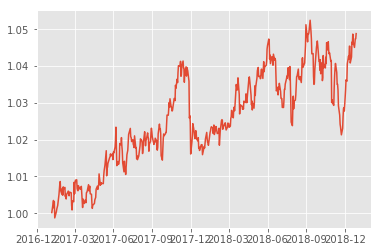

In [40]:
fac_1 = factor_return_list[0]
ret = (fac_1 + 1.0).cumprod() 
print(ret.loc[ret.index[-1],:])
print(ret.head())
plt.plot(ret)

In [41]:
fra_list = []
for key, val in factor_data.items():
    fra = al.performance.factor_rank_autocorrelation(val).to_frame()
    fra.columns = [key]
    fra_list.append(fra)
    
fra_df = pd.concat(fra_list, axis=1)

In [42]:
fra_df.head()

,factor,smoothed_factor
date,,
2017-01-06,NaN,NaN
2017-01-09,0.994066,0.998045
2017-01-10,0.991855,0.997932
2017-01-11,0.993474,0.998174
2017-01-12,0.991852,0.998207


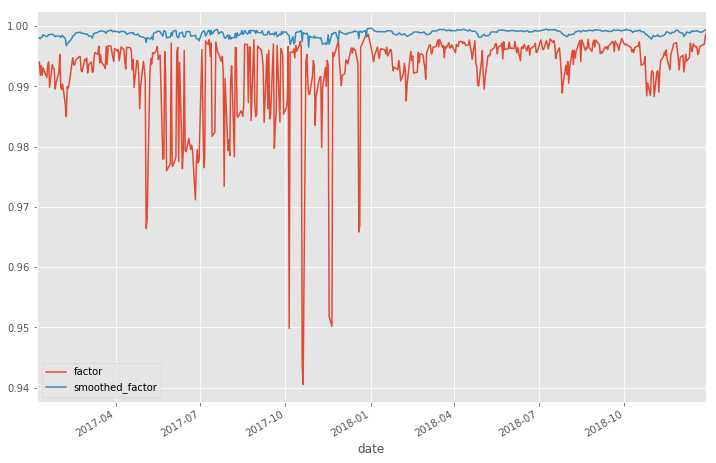

In [44]:
fra_df.plot(figsize=(12,8))